# Find all m-to-1 purification protocols (input: identical Werner states)

Here, we find the output fidelity and success probability of every bilocal Clifford protocol for $m$-to-1 purification using identical Werner states as input.

In [1]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from scipy.io import savemat

from tqdm.notebook import tqdm as tqdmn

## Functions

In [2]:
def base(M, n):
    # calculate the image of the base under a matrix M
    
    # make a set of all combinations of the first column and the last n columns (these correspond to X_1, Z_1,...,Z_n)
    s = []
    for i in range(n+1, 2*n):
        s.append(M[0:2*n, i])
    powerset = it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1))
    
    res = [vector(GF(2),2*n)]
        
    for i in powerset:
        v = vector(sum(i))     # calculate the sum of the elements of each combination (e.g IZZ = IZI + IIZ)
        res.append(v)
        
    return res

In [3]:
def pillars(M, n):
    # calculate the image of the pillars under a matrix M
    
    X1 = vector(M[0:2*n, 0])
    Z1 = vector(M[0:2*n, n])
    Y1 = X1 + Z1
    
    pI = base(M, n)
    pX = [(X1 + b) for b in pI]
    pY = [(Y1 + b) for b in pI]
    pZ = [(Z1 + b) for b in pI]
    
    return [pI, pX, pY, pZ]   

In [4]:
def tensor(A, n):
    # calculate the n fold tensor product of a matrix A
    
#    kron = A
#    count = 1
#    while count < n:
#        kron = np.kron(kron,A)
#        count = count + 1
#    if n == 2:
#        res = np.reshape(kron, (4,4))
#    elif n == 3:
#        res = np.reshape(kron, (4,4,4))
#    elif n == 4:
#        res = np.reshape(kron, (4,4,4,4))
#    elif n == 5:
#        res = np.reshape(kron, (4,4,4,4,4))
#    return res
    state = A
    for _ in range(n-1):
        state = np.kron(state,A)
    state = np.reshape(state, tuple([4 for _ in range(m)]))
    return state

In [5]:
def dist_stat(initial, M, n):
    # returns the success probability and the fidelity of an n-to-1 protocol M applied to an initial state
    pil = pillars(M, n)
    out = []
    for layer in pil:   
        coef = 0
        for elt in layer:
            if n == 2:
                coef = coef + initial[int(elt[0]) + 2*int(elt[n]), int(elt[1]) + 2*int(elt[n+1])]
            if n == 3:
                coef = coef + initial[int(elt[0]) + 2*int(elt[n]), int(elt[1]) + 2*int(elt[n+1]), \
                                   int(elt[2]) + 2*int(elt[n+2])]
            if n == 4:
                coef = coef + initial[int(elt[0]) + 2*int(elt[n]), int(elt[1]) + 2*int(elt[n+1]), \
                                   int(elt[2]) + 2*int(elt[n+2]), int(elt[3]) + 2*int(elt[n+3])]
            if n == 5:
                coef = coef + initial[int(elt[0]) + 2*int(elt[n]), int(elt[1]) + 2*int(elt[n+1]), \
                                   int(elt[2]) + 2*int(elt[n+2]), int(elt[3]) + 2*int(elt[n+3]), \
                                    int(elt[4]) + 2*int(elt[n+4])]
        out.append(coef)
    sp = sum(out)
    fid = out[0]/sp

    return round(sp,10), round(fid,10)

In [6]:
def sucprob_fid_lists(initial, transversal_inv, n):
    # calculate the possible distillation statistics (success probability & fidelity) of the protocols in a transversal
    # applied to an initial state
          
    fid = []
    sp = []
    fslist = set()
    for key, M in transversal_inv.items():
        s, f = dist_stat(initial, M, n)
        if (s,f) not in fslist:
            sp.append(s)
            fid.append(f)
            fslist.add((s,f))

    return sp, fid

## Calculate output F and probability of success for any input fidelity

In [17]:
# INPUTS
m = 3 # Number of input states
F_min = 0.25 # Minimum fidelity for any memory
F_max = 1 # Maximum fidelity for any memory
dF = 0.1 # Step size in fidelity calculation

In [13]:
# Load transversal
transversal_inv = load('%d_transversal_inv.sobj'%m)

In [14]:
# INPUT: IDENTICAL WERNER STATES

data = dict()

for F in tqdmn(np.arange(F_min,F_max+dF/2,dF)):
    F = round(F,2)

    # Werner state
    Werner_state = vector([F,(1-F)/3,(1-F)/3,(1-F)/3])
        
    # Tensor product
    init = tensor(Werner_state,m)

    # Solve
    probs, fids = sucprob_fid_lists(init, transversal_inv, m)

    # Save
    data[F] = {}
    data[F]['p'] = probs
    data[F]['F_out'] = fids

  0%|          | 0/8 [00:00<?, ?it/s]

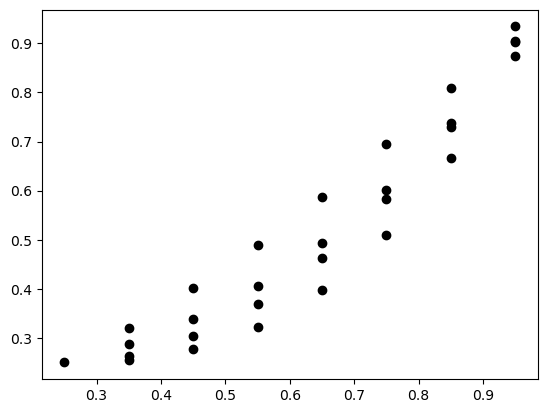

In [15]:
for F in data.keys():
    plt.scatter([F for _ in data[F]['p']], data[F]['p'], color='k')